In [2]:
pip install keras

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install sklearn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas_datareader.data as web
import datetime
import yfinance as yf
start = '2018-01-01'
end = '2023-01-01'
aapl = yf.download(["AAPL"],start, end)

[*********************100%***********************]  1 of 1 completed


In [6]:
aapl

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.888069,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.880951,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.070835,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.538445,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.384159,82271200
...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.658981,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.831772,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.847855,85438400


In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM,SimpleRNN,GRU
 
df_train = aapl[:1000]
df_test =  aapl[1000:]

In [8]:
df_train

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.888069,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.880951,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.070835,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.538445,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.384159,82271200
...,...,...,...,...,...,...
2021-12-14,175.250000,177.740005,172.210007,174.330002,173.059830,139380400
2021-12-15,175.110001,179.500000,172.309998,179.300003,177.993622,131063300
2021-12-16,179.279999,181.139999,170.750000,172.259995,171.004898,150185800


In [9]:

X_train_set = df_train.iloc[:,4:5].values  # Adj Close欄位
#特征标准化 - 正规化 
sc = MinMaxScaler() 
X_train_set = sc.fit_transform(X_train_set)
 
#取出几天前股价来建立成特征和标签数据集
def create_dataset(ds, look_back=1):
    X_data, Y_data = [],[]
    for i in range(len(ds)-look_back):
        X_data.append(ds[i:(i+look_back), 0])
        Y_data.append(ds[i+look_back, 0])
    return np.array(X_data), np.array(Y_data)
look_back = 60
print("回看天数:", look_back)
 
# 分割成特征数据和标签数据
X_train, Y_train = create_dataset(X_train_set, look_back)
 


回看天数: 60


In [10]:
# 转换成(样本数, 时步, 特征)张量  
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print("X_train.shape: ", X_train.shape)
print("Y_train.shape: ", Y_train.shape)

X_train.shape:  (940, 60, 1)
Y_train.shape:  (940,)


In [11]:
# 定义模型 
model = Sequential()
model.add(LSTM(50, return_sequences=True, 
               input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()   # 显示模型摘要资讯  
#编译模型
model.compile(loss="mse", optimizer="adam")
 
#训练模型
model.fit(X_train, Y_train, epochs=20, batch_size=32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [12]:
# 使用模型预测股价 - 2017年1~3月预测 4 月份股价
X_test_set = df_test.iloc[:,4:5].values
 
# 产生标签数据
_, Y_test = create_dataset(X_test_set, look_back)
 
#特征数据和标准化
X_test_s = sc.transform(X_test_set)
X_test,_ = create_dataset(X_test_s, look_back)
 
# 转换成(样本数, 时步, 特征)张量
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test_pred = model.predict(X_test)
 
#  将预测值转换回股价
X_test_pred_price = sc.inverse_transform(X_test_pred)

7/7 [==============================] - 1s 13ms/step


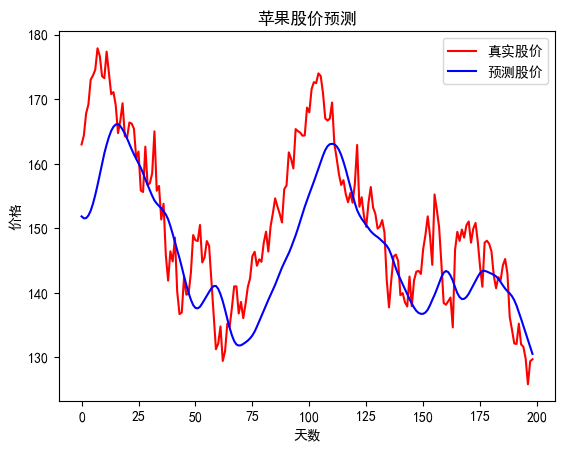

In [13]:
#  绘出股价图表  
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False
plt.plot(Y_test, color="red", label="真实股价")
plt.plot(X_test_pred_price, color="blue", label="预测股价")
plt.title("苹果股价预测",fontname="SimHei")
plt.xlabel("天数",fontname="SimHei")
plt.ylabel("价格",fontname="SimHei")
plt.legend()
plt.show()